# Virtual trip and planning advisor

**Applied Data Science Capstone Project**<br>
IBM Data Sceince Professional Certificate Specialization

## Table of Contents:<a class="anchor" id="toc"></a>
* [Introduction](#introduction)
* [Data Requirements](#data-requirements)
* [Methodology](#methodology)
* [Results and Discussion](#results-and-discussion)
* [Conclusion](#conclusion)

## Introduction<a class="anchor" id="introduction"></a>
[go to the top](#toc)

Hello, I would like to present to you a problem in the context of current related to pandemic self-isolation - all we are a bit bored while sitting at home and a lot of us are far from nature or fresh impressions.
It would be nice to get some joy from photos of wild nature or nice landscapes now and make a plan to visit natural landmarks near as soon as self-isolation ends.

We would like to determine beautiful places, landmarks, and compilation to look at for now and probably to visit in the future. Kind of virtual trip and planning advisor.

This project it more social-oriented, but some business holders might be interested in it also in order to develop nearest infrastructure and attract more customers.

## Data Requirements<a class="anchor" id="data-requirements"></a>
[go to the top](#toc)

Firstly, we need a list of interesting outdoor places, after that we need places near first ones in relatively close distance to build a compilations of such and related places.<br>
We will use Foursquare API to obtain needed information:
* Venue name
* Venue categories
* Venue latitude, and longitude location

We will perform __trending__ query to get a list popular outdoor places and __search__ query to obtain lists of closest venues to first ones. 


## Methodology<a class="anchor" id="methodology"></a>
[go to the top](#toc)

I used data from Wikipedia and Foursquare to make a clustering of some regions of Ukrainian part of Carpathian Mountains based on outdoor places.
Next data were used: 
* list of mountain peaks with its locations and coordinates,
* lists of nearest to mountain peak venues with its names, categories and coordinates

In this study I was using k-Means algorithm to make such kind of clustering: mountain peaks were chosen as item to clustering and nearest outdoor venues by categories were chosen as features to be processed with help of k-Means algorithm. As venues have common categories, the k-Means algorithm suits well and is common to perform such kind of task.

With help of elbow method was determined optimal number of clusters.

After clustering each cluster was assigned related name from observation.

Installing and Importing all necessary libraries and modules, also function definition to display progress bars<br>
cretids for progress bar is going to https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/

In [1]:
import pandas as pd
import numpy as np
import requests
import re
from sklearn.cluster import KMeans

import time, sys
from IPython.display import clear_output

# progress bar visualization
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [23]:
# adding world map
!pip install folium
import folium
from geopy.geocoders import Nominatim

# a bit of internationalization
!pip install unidecode
from unidecode import unidecode

# adding sql magic
!pip install --user ipython-sql --no-warn-script-location
!pip install --user ibm_db
!pip install --user ibm_db_sa

%load_ext sql

# add yeallowbrick to make an elbow estimation k for k-Means
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

The sql extension is already loaded. To reload it, use:
  %reload_ext sql
     |████████████████████████████████| 266kB 10.1MB/s eta 0:00:01


Credentials and DB2 connection.

In [3]:
# The code was removed by Watson Studio for sharing.

In [4]:
import urllib

# url = 'https://uk.wikipedia.org/wiki/Вершини_Українських_Карпат'
url = 'https://uk.wikipedia.org/wiki/%D0%92%D0%B5%D1%80%D1%88%D0%B8%D0%BD%D0%B8_%D0%A3%D0%BA%D1%80%D0%B0%D1%97%D0%BD%D1%81%D1%8C%D0%BA%D0%B8%D1%85_%D0%9A%D0%B0%D1%80%D0%BF%D0%B0%D1%82'

try:
    mountain_peaks = pd.read_html(url)
except urllib.error.HTTPError as err:
    raise SystemExit(err)

mountain_peaks = mountain_peaks[0]
mountain_peaks[:5]

,Назва,Висота(по картах генштаба),Де розташована,Координати
0,Говерла,2061.0,Чорногора,48°09′04″ пн. ш. 24°30′00″ сх. д.﻿ / ﻿48.15111...
1,Бребенескул,2035.8,Чорногора,48°05′54″ пн. ш. 24°34′50″ сх. д.﻿ / ﻿48.09833...
2,Піп Іван Чорногорський,2028.5,Чорногора,48°02′52″ пн. ш. 24°37′40″ сх. д.﻿ / ﻿48.04778...
3,Петрос,2022.5,Чорногора,48°10′19″ пн. ш. 24°25′16″ сх. д.﻿ / ﻿48.17194...
4,Гутин Томнатик,2016.4,Чорногора,48°06′00″ пн. ш. 24°33′24″ сх. д.﻿ / ﻿48.10000...


In [5]:
mountain_peaks.shape

(122, 4)

Create database table to store data about mountain peaks.

In [6]:
%%sql
drop table MOUNTAINS;

create table MOUNTAINS (
	id INTEGER NOT NULL GENERATED ALWAYS AS IDENTITY (START WITH 1 INCREMENT BY 1),
	name VARCHAR(200) NOT NULL,
	height NUMERIC(5,1) NOT NULL,
	location VARCHAR(100) NOT NULL,
	latitude NUMERIC(20,17) NOT NULL,
	longitude NUMERIC(20,17) NOT NULL,
	PRIMARY KEY (id)
);

 * ibm_db_sa://cdj80529:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.
Done.


[]

Let's extract Latitude and Longitute coordinates from Location field and put data into the database and add record's id to dataframe

credits for DB2 implementation of SQL statement is going to<br> 
https://stackoverflow.com/questions/3087836/how-to-get-the-last-insert-id-from-a-table#comment45107599_3088816

In [7]:
mountain_peaks.columns = ['Name', 'Height', 'Location', 'Coordinates']

pattern = re.compile('(?P<Latitude>[0-9]+\.[0-9]+)°.*\s(?P<Longitude>[0-9]+\.[0-9]+)°')

for i, name, height, location, coordinates in mountain_peaks.itertuples():
    # a bit of internationalization
    name = unidecode(name)
    location = unidecode(location)
    latitude, longitude = pattern.search(coordinates).groups()
    
    # put values into a database and obtain assigned id
    mountain = %sql SELECT * FROM FINAL TABLE (insert into MOUNTAINS (name, height, location, latitude, longitude) values (:name, :height, :location, :latitude, :longitude));
    mountain_peaks.at[i, 'id'] = int(mountain.dict()['id'][0])
    mountain_peaks.at[i, 'Name'] = name
    mountain_peaks.at[i, 'Location'] = location
    mountain_peaks.at[i, 'Latitude'] = latitude
    mountain_peaks.at[i, 'Longitude'] = longitude
    update_progress((i+1) / len(mountain_peaks))

mountain_peaks['id'] = mountain_peaks['id'].astype(int)
mountain_peaks.drop(['Coordinates'], axis = 1, inplace = True)
mountain_peaks.head()

Progress: [####################] 100.0%


,Name,Height,Location,id,Latitude,Longitude
0,Goverla,2061.0,Chornogora,1,48.15111,24.50000
1,Brebeneskul,2035.8,Chornogora,2,48.09833,24.58056
2,Pip Ivan Chornogors'kii,2028.5,Chornogora,3,48.04778,24.62778
3,Petros,2022.5,Chornogora,4,48.17194,24.42111
4,Gutin Tomnatik,2016.4,Chornogora,5,48.10000,24.55667


In [8]:
mountain_peaks.shape

(122, 6)

In [9]:
# address = 'Carpathian Biosphere Reserve'
address = 'Карпатський біосферний заповідник'

geolocator = Nominatim(user_agent="ibm_data_science_certification_explorer")
carpathian_coords = geolocator.geocode(address)

carpathian_map = folium.Map(
    location=[carpathian_coords.latitude, carpathian_coords.longitude],
    zoom_start=9
)

# add markers to map
for i, row in mountain_peaks.iterrows():
    folium.CircleMarker(
        [row['Latitude'], row['Longitude']],
        radius = 5,
        popup = folium.Popup(unidecode(row['Name']), parse_html=True),
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False
    ).add_to(carpathian_map)  
    
carpathian_map

Let's create tables for sights and its relations to mountain peaks.

In [10]:
%%sql
drop table SIGHTS;
drop table MOUNTAIN_SIGHTS;

create table SIGHTS (
	id INTEGER NOT NULL GENERATED ALWAYS AS IDENTITY (START WITH 1 INCREMENT BY 1),
	name VARCHAR(200) NOT NULL,
	category VARCHAR(100) NOT NULL,
	latitude NUMERIC(8,5) NOT NULL,
	longitude NUMERIC(8,5) NOT NULL,
	PRIMARY KEY (id)
);

create table MOUNTAIN_SIGHTS (
	mountain_id INTEGER NOT NULL,
	sight_id INTEGER NOT NULL,
	PRIMARY KEY (mountain_id, sight_id)
)

 * ibm_db_sa://cdj80529:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.
Done.
Done.
Done.


[]

Let's grab nearest sights with Foursquare API, and put it into database

In [11]:
# Outdoors & Recreation
categories = ['4d4b7105d754a06377d81259']
radius = 2000
limit = 200

sights = []
for i, row in mountain_peaks.iterrows():
    # Foursquare API requests
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, row['Latitude'], row['Longitude'], ','.join(categories), radius, limit)
    results = requests.get(url).json()["response"]['venues']

    mountain_id = row['id']
    
    # Pushing into database and list
    for item in results:
        name = item['name']
        #  name.index(' (') name.index(' /') unidecode(name)
        category = item['categories'][0]['name']
        latitude = item['location']['lat']
        longitude = item['location']['lng']
        
        sight = %sql select * from SIGHTS where name = :name and category = :category and latitude = :latitude and longitude = :longitude;
        
        if len(sight) == 0:
            sight = %sql SELECT * FROM FINAL TABLE (insert into SIGHTS (name, category, latitude, longitude) values (:name, :category, :latitude, :longitude));
            sights.append(sight[0])

        sight_id = sight[0]['id']
        %sql insert into MOUNTAIN_SIGHTS (mountain_id, sight_id) values (:mountain_id, :sight_id)
    
    update_progress((i+1) / len(mountain_peaks))
    
sights = pd.DataFrame(sights)
sights.columns = ['id', 'Name', 'Category', 'Latitude', 'Longitude']
sights.head()

Progress: [####################] 100.0%


,id,Name,Category,Latitude,Longitude
0,1,Говерла (2061 м) / Hoverla,Mountain,48.16039,24.50037
1,2,Брескул (1911 м) / Breskul,Mountain,48.15037,24.51103
2,3,Гірське Крісло,Other Great Outdoors,48.16272,24.50573
3,4,Говерлянка,Mountain,48.16615,24.50546
4,5,Пожижевська (1822 м),Mountain,48.14430,24.52357


In [12]:
sights.shape

(189, 5)

Create DB2 tables.

Group rows by mountain peaks as sights and by taking the mean of the frequency of occurrence of each place by category.<br>
Let's join data from both tables first.

In [13]:
mountain_to_sights = %sql select * from MOUNTAIN_SIGHTS;
mountain_to_sights = mountain_to_sights.DataFrame()

mountain_sights = mountain_to_sights.join(mountain_peaks.set_index('id'), on = 'mountain_id').join(sights.set_index('id'), on = 'sight_id', rsuffix = ' Sight')
mountain_sights.head()

 * ibm_db_sa://cdj80529:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


,mountain_id,sight_id,Name,Height,Location,Latitude,Longitude,Name Sight,Category,Latitude Sight,Longitude Sight
0,1,1,Goverla,2061.0,Chornogora,48.15111,24.50000,Говерла (2061 м) / Hoverla,Mountain,48.16039,24.50037
1,1,2,Goverla,2061.0,Chornogora,48.15111,24.50000,Брескул (1911 м) / Breskul,Mountain,48.15037,24.51103
2,1,3,Goverla,2061.0,Chornogora,48.15111,24.50000,Гірське Крісло,Other Great Outdoors,48.16272,24.50573
3,1,4,Goverla,2061.0,Chornogora,48.15111,24.50000,Говерлянка,Mountain,48.16615,24.50546
4,1,5,Goverla,2061.0,Chornogora,48.15111,24.50000,Пожижевська (1822 м),Mountain,48.14430,24.52357


Let's look at count of sights near each mountain peak.

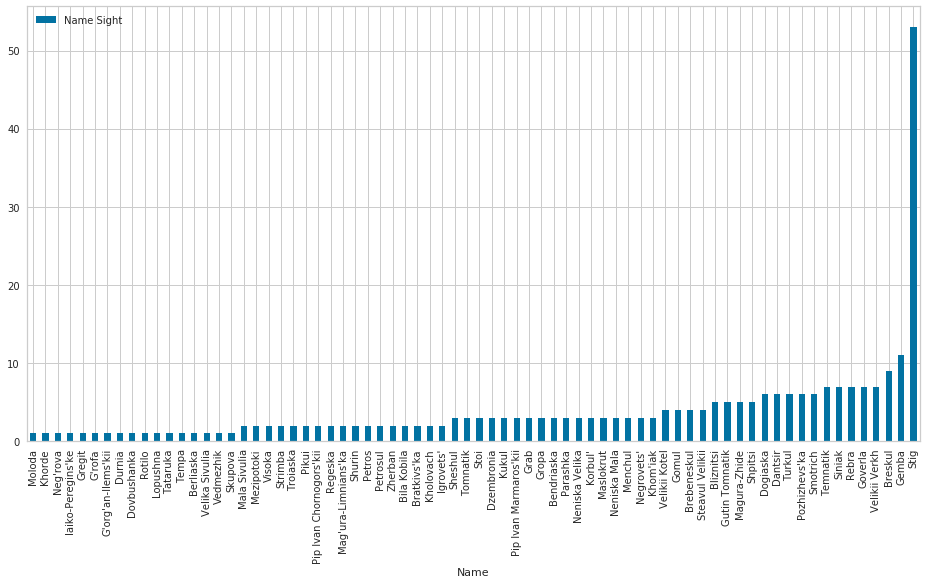

In [66]:
mountain_sights.groupby('Name').count().sort_values(by = 'Name Sight').plot(kind = 'bar', y = 'Name Sight', figsize = (16, 8))

In [50]:
# group by mean
sights_categories = mountain_sights[['Name']].join(pd.get_dummies(sights[['Category']])).groupby('Name').mean().reset_index()
sights_categories.dropna(inplace = True)
sights_categories.head()

,Name,Category_Apres Ski Bar,Category_Athletics & Sports,Category_Campground,Category_Field,Category_Forest,Category_Lake,Category_Mountain,Category_National Park,Category_Other Great Outdoors,...,Category_Ski Area,Category_Ski Chairlift,Category_Ski Chalet,Category_Ski Lodge,Category_Sports Club,Category_Summer Camp,Category_Trail,Category_Vineyard,Category_Waterfall,Category_Well
3,Bliznitsi,0.0,0.0,0.0,0.000000,0.0,0.40,0.400000,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bratkivs'ka,0.5,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Brebeneskul,0.0,0.0,0.0,0.000000,0.0,0.25,0.750000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Breskul,0.0,0.0,0.0,0.000000,0.0,0.00,0.777778,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Dantsir,0.0,0.0,0.0,0.166667,0.0,0.00,0.833333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
sights_categories.shape

(44, 24)

#### Let's study data and apply k-Mean clustering
Determine top categories for each mountain peak.

In [54]:
num_top_categories = 5
indicators = ['st', 'nd', 'rd']
# create columns according to number of top categories
columns = ['Name']

for ind in np.arange(num_top_categories):
    try:
        columns.append('{}{}'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th'.format(ind+1))

# create a new dataframe
top_categories = pd.DataFrame(columns=columns)
top_categories['Name'] = sights_categories['Name']

for ind in np.arange(sights_categories.shape[0]):
    top_categories.iloc[ind, 1:] = sights_categories.iloc[ind, :].iloc[1:].sort_values(ascending=False).index.values[0:num_top_categories]
    
top_categories.head()

,Name,1st,2nd,3rd,4th,5th
3,Bliznitsi,Category_Lake,Category_Mountain,Category_Other Great Outdoors,Category_Well,Category_River
4,Bratkivs'ka,Category_Apres Ski Bar,Category_Ski Chalet,Category_River,Category_Athletics & Sports,Category_Campground
5,Brebeneskul,Category_Mountain,Category_Lake,Category_Well,Category_River,Category_Athletics & Sports
6,Breskul,Category_Mountain,Category_Scenic Lookout,Category_Well,Category_River,Category_Athletics & Sports
7,Dantsir,Category_Mountain,Category_Field,Category_Well,Category_River,Category_Athletics & Sports


Let's build k-means model to cluster the neighborhood into 6 clusters.

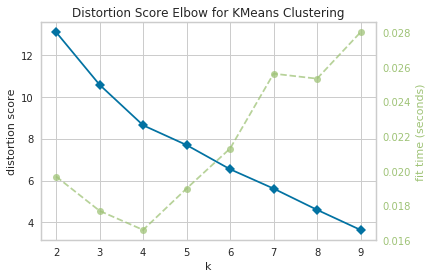

In [32]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10), locate_elbow=False)

visualizer.fit(sights_categories.drop(['mountain_id', 'Name'], 1))        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [55]:
# set number of clusters
k = 6

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(sights_categories.drop(['Name'], 1).dropna())

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 5, 1, 1, 1, 2, 5, 4, 1, 5, 2, 0, 5, 1, 2, 2, 2, 0, 1, 1, 1, 4,
       2, 1, 1, 1, 0, 4, 0, 0, 1, 2, 0, 2, 0, 1, 4, 4, 0, 1, 2, 2, 3, 5],
      dtype=int32)

In [42]:
top_categories.insert(0, 'Cluster', kmeans.labels_)

mountains_merged = mountain_peaks.join(top_categories.set_index('Name'), on='Name')
mountains_merged.dropna(inplace = True)
mountains_merged.head(100)

,Name,Height,Location,id,Latitude,Longitude,Cluster,mountain_id,1st,2nd,3rd,4th,5th
0,Goverla,2061.0,Chornogora,1,48.15111,24.50000,0.0,1.000000,Category_Mountain,Category_Campground,Category_Other Great Outdoors,Category_Waterfall,Category_Well
1,Brebeneskul,2035.8,Chornogora,2,48.09833,24.58056,1.0,2.000000,Category_Mountain,Category_Lake,Category_Well,Category_River,Category_Athletics & Sports
2,Pip Ivan Chornogors'kii,2028.5,Chornogora,3,48.04778,24.62778,1.0,3.000000,Category_Mountain,Category_Well,Category_River,Category_Athletics & Sports,Category_Campground
3,Petros,2022.5,Chornogora,4,48.17194,24.42111,1.0,4.000000,Category_Mountain,Category_Well,Category_River,Category_Athletics & Sports,Category_Campground
4,Gutin Tomnatik,2016.4,Chornogora,5,48.10000,24.55667,1.0,5.000000,Category_Mountain,Category_Lake,Category_Well,Category_River,Category_Athletics & Sports
5,Rebra,2001.1,Chornogora,6,48.11111,24.55833,0.0,6.000000,Category_Mountain,Category_Other Great Outdoors,Category_Recreation Center,Category_Well,Category_River
6,Menchul,1998.4,Chornogora,7,48.09167,24.59583,0.0,7.000000,Category_Mountain,Category_Waterfall,Category_Well,Category_River,Category_Athletics & Sports
7,Pip Ivan Marmaros'kii,1937.7,Marmaros'kii masiv,8,47.92444,24.32611,0.0,8.000000,Category_Campground,Category_Mountain,Category_Waterfall,Category_Well,Category_River
8,Turkul,1933.2,Chornogora,9,48.12389,24.53000,0.0,9.000000,Category_Mountain,Category_Lake,Category_Other Great Outdoors,Category_Well,Category_River
9,Breskul,1911.0,Chornogora,10,48.15083,24.51194,1.0,10.000000,Category_Mountain,Category_Scenic Lookout,Category_Well,Category_River,Category_Athletics & Sports


Let's look at count of peaks in clusters.

In [71]:
mountains_merged.groupby('Cluster').count()

,Name,Height,Location,id,Latitude,Longitude,mountain_id,1st,2nd,3rd,4th,5th
Cluster,,,,,,,,,,,,
0.0,10,10,10,10,10,10,10,10,10,10,10,10
1.0,15,15,15,15,15,15,15,15,15,15,15,15
2.0,10,10,10,10,10,10,10,10,10,10,10,10
3.0,1,1,1,1,1,1,1,1,1,1,1,1
4.0,5,5,5,5,5,5,5,5,5,5,5,5
5.0,5,5,5,5,5,5,5,5,5,5,5,5


In [67]:
cluster_names = ['Lakes', 'Mountains', 'Ski Lodges', 'Hills', 'Forests', 'Ski Services']

In [68]:
mountains_merged.shape

(46, 13)

Let's display results on a map.

In [69]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import math

carpathian_clustered_map = folium.Map(
    location=[carpathian_coords.latitude, carpathian_coords.longitude],
    zoom_start=9
)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

map_feature_groups = {}
legend_text = '<span style="color: {color};">{txt}</span>'
for i, name in enumerate(cluster_names):
    map_feature_groups[name] = folium.FeatureGroup(name = legend_text.format(txt = cluster_names[i], color = rainbow[i-1]))
    carpathian_clustered_map.add_child(map_feature_groups[name])
    
for i, row in mountains_merged[['Latitude', 'Longitude', 'Name', 'Cluster']].iterrows():
    if math.isnan(row['Cluster']):
        continue
    
    feature_group = map_feature_groups[cluster_names[int(row['Cluster'])]]
    
    label = folium.Popup(str(row['Name']), parse_html=True)
    marker = folium.CircleMarker(
        [row['Latitude'], row['Longitude']],
        radius=5,
        popup=label,
        color=rainbow[int(row['Cluster']-1)],
        fill=True,
        fill_color=rainbow[int(row['Cluster']-1)],
        fill_opacity=0.7
    )#.add_to(feature_group)
    feature_group.add_child(marker)
    
folium.map.LayerControl('topleft', collapsed= False).add_to(carpathian_clustered_map)
carpathian_clustered_map

## Results and Discussion<a class="anchor" id="results-and-discussion"></a>
[go to the top](#toc)

As result of this work we have discovered 6 clusters: Lakes, Mountains, Ski Lodges, Hills, Forest, Ski Services and mark related mountain peaks in order of belonging to cluster. 

* Lakes – 10 mountain peaks
* Mountains – 15 mountain peaks
* Ski Lodges – 10 mountain peaks
* Hills – 1 mountain peak
* Forest – 5 mountain peaks
* Ski Services – 5 mountain peaks

More precision estimation of cluster names may be needed. Also, datasets were small, but algorithms perform well and we will need larger amounts of data to get better and more accurate results. 

## Conclusion<a class="anchor" id="conclusion"></a>
[go to the top](#toc)

As a result, we can build different kind of web services or applications using a result of our work, to determine type of nearest outdoor places and group by these features. People can use this data to make a better plan for their trips and achieve better satisfaction, or enjoy performing searches of pictures based on this result, business owners can develop their businesses and use these data to determine proper customer's needs.

## References<a class="anchor" id="references"></a>
[go to the top](#toc)

* [1] [Wikipedia: Ukrainian Carpathian Peaks](https://uk.wikipedia.org/wiki/%D0%92%D0%B5%D1%80%D1%88%D0%B8%D0%BD%D0%B8_%D0%A3%D0%BA%D1%80%D0%B0%D1%97%D0%BD%D1%81%D1%8C%D0%BA%D0%B8%D1%85_%D0%9A%D0%B0%D1%80%D0%BF%D0%B0%D1%82)
* [2] [Foursquare API](https://developer.foursquare.com/docs/)
* [3] [IBM Data Science Lab: Segmenting and Clustering Neighborhoods in New York City](https://www.coursera.org/learn/applied-data-science-capstone/ungradedLti/f0QY7/segmenting-and-clustering-neighborhoods-in-new-york-city)
* [4] [Folium Map Legend](https://stackoverflow.com/a/58077924)